<a href="https://colab.research.google.com/github/greo234/telediagnosiswithBERT/blob/main/TelemedicineBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
filepath = 'https://raw.githubusercontent.com/greo234/telediagnosiswithBERT/main/text%20and%20symptoms_2.csv'

df = pd.read_csv(filepath)
df.drop(df.columns[0], axis=1, inplace=True)
df

,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis
...,...,...
1195,I'm shaking and trembling all over. I've lost ...,diabetes
1196,"Particularly in the crevices of my skin, I hav...",diabetes
1197,I regularly experience these intense urges and...,diabetes
1198,"I have trouble breathing, especially outside. ...",diabetes


In [4]:
df.head()

,Patient_Problem,Disease
0,I have been experiencing a skin rash on my arm...,Psoriasis
1,"My skin has been peeling, especially on my kne...",Psoriasis
2,I have been experiencing joint pain in my fing...,Psoriasis
3,"There is a silver like dusting on my skin, esp...",Psoriasis
4,"My nails have small dents or pits in them, and...",Psoriasis


In [5]:
df.isnull().sum()

Patient_Problem    0
Disease            0
dtype: int64

In [6]:
#disease count
disease_count = df['Disease'].value_counts()
disease_count

Disease
Psoriasis                          50
Varicose Veins                     50
Typhoid                            50
Chicken pox                        50
Impetigo                           50
Dengue                             50
Fungal infection                   50
Common Cold                        50
Pneumonia                          50
Dimorphic Hemorrhoids              50
Arthritis                          50
Acne                               50
Bronchial Asthma                   50
Hypertension                       50
Migraine                           50
Cervical spondylosis               50
Jaundice                           50
Malaria                            50
urinary tract infection            50
allergy                            50
gastroesophageal reflux disease    50
drug reaction                      50
peptic ulcer disease               50
diabetes                           50
Name: count, dtype: int64

<ipython-input-7-47a223818950>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


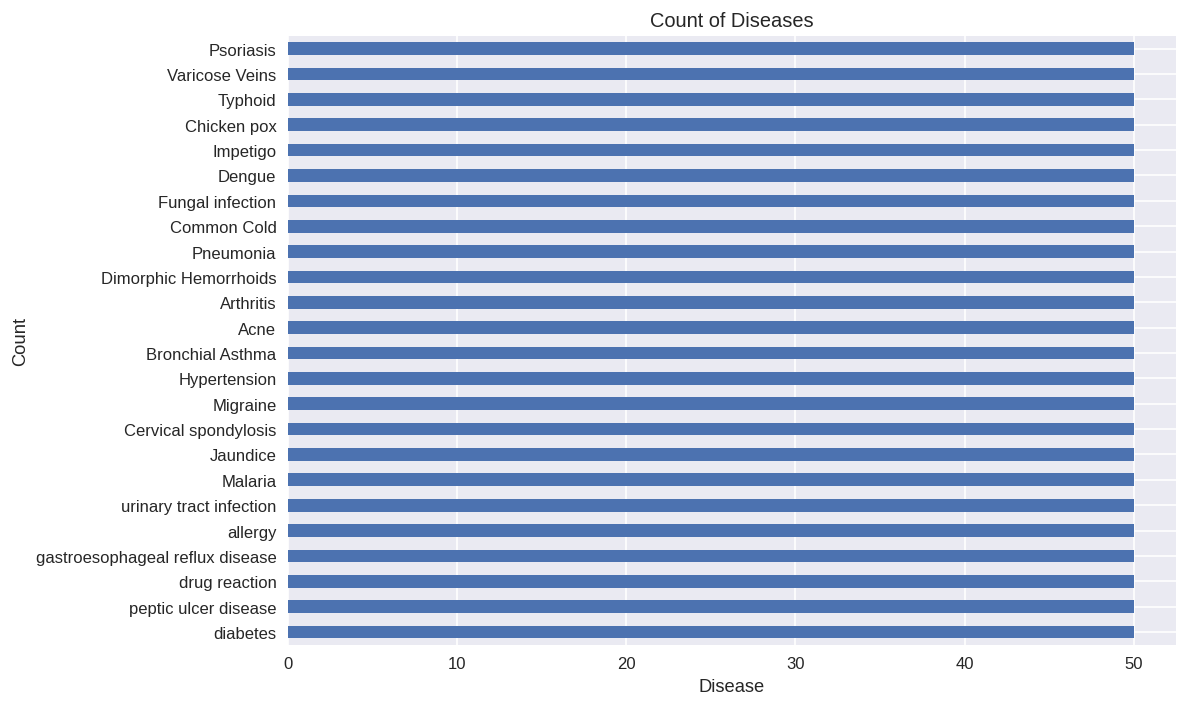

In [7]:
# Plot the disease count
plt.style.use('seaborn')
plt.figure(figsize=(10, 6), dpi=120)
disease_count.plot(kind='barh')
plt.title('Count of Diseases')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
#Total Number of diseases
print('Total number of Diseases: %d'%(len(df['Disease'].value_counts().index)))

Total number of Diseases: 24


In [9]:
from sklearn.model_selection import train_test_split
med_data = df
# Splitting the dataset into training and test sets for 'Patient_Problem' and 'Disease'
X, y_disease = med_data['Patient_Problem'], med_data['Disease']
X_train, problem_test, y_disease_train, disease_test = train_test_split(X, y_disease, stratify=y_disease, test_size=0.1, random_state=4612)

# Further splitting the training set into training and validation sets
problem_train, problem_val, disease_train, disease_val = train_test_split(X_train, y_disease_train, stratify=y_disease_train, test_size=0.20, random_state=4612)

In [10]:
print(f"samples in training set: {problem_train.shape[0]}\nsamples in validation set: {problem_val.shape[0]}\nsamples in test set: {problem_test.shape[0]}")

samples in training set: 864
samples in validation set: 216
samples in test set: 120


In [11]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer with a pretrained model (e.g., 'bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

max_len = 0
input_ids = []

# For every problem...
for problem in problem_train:
    # Tokenize the problem and add special tokens--`[CLS]` and `[SEP]` tokens.
    tokens = tokenizer.encode(problem, add_special_tokens=True)
    input_ids.append(tokens)

    # Update the maximum sentence length.
    max_len = max(max_len, len(tokens))

# Calculate mean sentence length
mean_len = sum(len(tokens) for tokens in input_ids) / len(input_ids)

# Print the results
print('Max sentence length: %d \nMean sentence length: %d' % (max_len, mean_len))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Max sentence length: 79 
Mean sentence length: 43


In [12]:
def tokenize(problem):
  """
    Tokenize patient problems using the specified tokenizer.

    Returns:
    dict: Dictionary containing the tokenized inputs.
    """
  batch = tokenizer(list(problem),
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch

In [13]:
token_train = tokenize(problem_train)
token_val = tokenize(problem_val)
token_test = tokenize(problem_test)

In [14]:
# Check the type and shape of the tokenized data
print(type(token_train))
print(len(token_train))

# Print the first few examples of the tokenized data
print(token_train[:5])

<class 'transformers.tokenization_utils_base.BatchEncoding'>
3
{'input_ids': tensor([[  101,   146,  1579,  1243,   170, 17948,  5080,  1107,  1139,  1779,
           117,  1256,  1165,   146,  1274,   112,   189,  1138,  1625, 27675,
          1107,  1139,  3472,   119,   146,  4857,  1138,  1103, 20844, 19515,
         17210,  1105,   170, 13094,  1107,  1139,  2922,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1422, 10880,  1110,  1541,  1344,   117,  1105,   146,   112,
           182,  1515,  3819,  9256,  1139,  2184,   119,   146,   112,   182,
         21234,   170,  1974,   117,  2296,  2504,  1105,  4871,   117,  1105,
          1139,  1762,  1110,  5405,  1541,  2698,   119,   

In [15]:
print("Input IDs:")
print(token_train['input_ids'][0])

# Print token type IDs for the first training example
print("Token Type IDs:")
print(token_train['token_type_ids'][0])

# Print attention mask for the first training example
print("Attention Mask:")
print(token_train['attention_mask'][0])

Input IDs:
tensor([  101,   146,  1579,  1243,   170, 17948,  5080,  1107,  1139,  1779,
          117,  1256,  1165,   146,  1274,   112,   189,  1138,  1625, 27675,
         1107,  1139,  3472,   119,   146,  4857,  1138,  1103, 20844, 19515,
        17210,  1105,   170, 13094,  1107,  1139,  2922,   119,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
Token Type IDs:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])
Attention Mask:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [16]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [17]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(disease_train)))
label_val = torch.tensor((LE.fit_transform(disease_val)))
label_test = torch.tensor((LE.fit_transform(disease_test)))

In [18]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(token_train['input_ids'], token_train['attention_mask'],label_train)
val_data = TensorDataset(token_val['input_ids'], token_val['attention_mask'],label_val)
test_data = TensorDataset(token_test['input_ids'], token_test['attention_mask'],label_test)

Training with learning rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

Epoch 1/20:
  Training Loss: 3.1814, Accuracy: 0.0718, Recall: 0.0718, F1: 0.0446, AROC: 0.5157, Precision: 0.0508


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 3.0510, Accuracy: 0.0911, Recall: 0.0926, F1: 0.0428, AROC: 0.5266, Precision: 0.0379


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 2/20:
  Training Loss: 3.0013, Accuracy: 0.1285, Recall: 0.1285, F1: 0.0976, AROC: 0.5453, Precision: 0.1017


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 2.8464, Accuracy: 0.2331, Recall: 0.2454, F1: 0.1858, AROC: 0.6063, Precision: 0.1754


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 3/20:
  Training Loss: 2.7433, Accuracy: 0.3252, Recall: 0.3252, F1: 0.2828, AROC: 0.6479, Precision: 0.3052


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 2.5895, Accuracy: 0.4701, Recall: 0.4722, F1: 0.4066, AROC: 0.7246, Precision: 0.4347


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 4/20:
  Training Loss: 2.4844, Accuracy: 0.5069, Recall: 0.5069, F1: 0.4666, AROC: 0.7428, Precision: 0.4975


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 2.3049, Accuracy: 0.6068, Recall: 0.6111, F1: 0.5599, AROC: 0.7971, Precision: 0.5824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 5/20:
  Training Loss: 2.2017, Accuracy: 0.6620, Recall: 0.6620, F1: 0.6305, AROC: 0.8237, Precision: 0.6824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 2.0417, Accuracy: 0.7044, Recall: 0.7037, F1: 0.6719, AROC: 0.8454, Precision: 0.7342


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 6/20:
  Training Loss: 1.9681, Accuracy: 0.7500, Recall: 0.7500, F1: 0.7140, AROC: 0.8696, Precision: 0.7258


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 1.8001, Accuracy: 0.7839, Recall: 0.7824, F1: 0.7580, AROC: 0.8865, Precision: 0.8056


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 7/20:
  Training Loss: 1.7518, Accuracy: 0.8160, Recall: 0.8160, F1: 0.7931, AROC: 0.9040, Precision: 0.8238


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 1.6152, Accuracy: 0.7812, Recall: 0.7870, F1: 0.7631, AROC: 0.8889, Precision: 0.7992


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 8/20:
  Training Loss: 1.5662, Accuracy: 0.8542, Recall: 0.8542, F1: 0.8446, AROC: 0.9239, Precision: 0.8805


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 1.4397, Accuracy: 0.8008, Recall: 0.8102, F1: 0.7898, AROC: 0.9010, Precision: 0.8145


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 9/20:
  Training Loss: 1.3980, Accuracy: 0.8843, Recall: 0.8843, F1: 0.8759, AROC: 0.9396, Precision: 0.8990


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 1.3121, Accuracy: 0.8203, Recall: 0.8333, F1: 0.8159, AROC: 0.9130, Precision: 0.8348


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 10/20:
  Training Loss: 1.2515, Accuracy: 0.9294, Recall: 0.9294, F1: 0.9261, AROC: 0.9632, Precision: 0.9454


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 1.1835, Accuracy: 0.8503, Recall: 0.8611, F1: 0.8431, AROC: 0.9275, Precision: 0.8546


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 11/20:
  Training Loss: 1.1297, Accuracy: 0.9375, Recall: 0.9375, F1: 0.9346, AROC: 0.9674, Precision: 0.9527


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 1.0812, Accuracy: 0.8750, Recall: 0.8750, F1: 0.8597, AROC: 0.9348, Precision: 0.8583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 12/20:
  Training Loss: 1.0239, Accuracy: 0.9595, Recall: 0.9595, F1: 0.9583, AROC: 0.9789, Precision: 0.9688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 0.9875, Accuracy: 0.8867, Recall: 0.8889, F1: 0.8760, AROC: 0.9420, Precision: 0.8782


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 13/20:
  Training Loss: 0.9238, Accuracy: 0.9734, Recall: 0.9734, F1: 0.9727, AROC: 0.9861, Precision: 0.9824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 0.9104, Accuracy: 0.9010, Recall: 0.8981, F1: 0.8855, AROC: 0.9469, Precision: 0.8967


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/20:
  Training Loss: 0.8566, Accuracy: 0.9780, Recall: 0.9780, F1: 0.9776, AROC: 0.9885, Precision: 0.9878


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.8436, Accuracy: 0.9206, Recall: 0.9213, F1: 0.9121, AROC: 0.9589, Precision: 0.9174


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/20:
  Training Loss: 0.7934, Accuracy: 0.9815, Recall: 0.9815, F1: 0.9812, AROC: 0.9903, Precision: 0.9879


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.7937, Accuracy: 0.9062, Recall: 0.9120, F1: 0.9026, AROC: 0.9541, Precision: 0.8991


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/20:
  Training Loss: 0.7438, Accuracy: 0.9792, Recall: 0.9792, F1: 0.9788, AROC: 0.9891, Precision: 0.9859


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.7474, Accuracy: 0.9206, Recall: 0.9213, F1: 0.9152, AROC: 0.9589, Precision: 0.9278


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/20:
  Training Loss: 0.7079, Accuracy: 0.9884, Recall: 0.9884, F1: 0.9884, AROC: 0.9940, Precision: 0.9903


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.7251, Accuracy: 0.9271, Recall: 0.9213, F1: 0.9154, AROC: 0.9589, Precision: 0.9427


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/20:
  Training Loss: 0.6804, Accuracy: 0.9907, Recall: 0.9907, F1: 0.9907, AROC: 0.9952, Precision: 0.9916


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.6998, Accuracy: 0.9310, Recall: 0.9259, F1: 0.9198, AROC: 0.9614, Precision: 0.9434


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/20:
  Training Loss: 0.6619, Accuracy: 0.9931, Recall: 0.9931, F1: 0.9930, AROC: 0.9964, Precision: 0.9957


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.6847, Accuracy: 0.9310, Recall: 0.9259, F1: 0.9198, AROC: 0.9614, Precision: 0.9434


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/20:
  Training Loss: 0.6560, Accuracy: 0.9907, Recall: 0.9907, F1: 0.9907, AROC: 0.9952, Precision: 0.9943


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.6775, Accuracy: 0.9349, Recall: 0.9306, F1: 0.9254, AROC: 0.9638, Precision: 0.9457
Training with learning rate: 0.0001


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

Epoch 1/20:
  Training Loss: 3.1032, Accuracy: 0.0880, Recall: 0.0880, F1: 0.0727, AROC: 0.5242, Precision: 0.0606


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 2.6527, Accuracy: 0.3516, Recall: 0.3472, F1: 0.2733, AROC: 0.6594, Precision: 0.3246


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 2/20:
  Training Loss: 2.0542, Accuracy: 0.5752, Recall: 0.5752, F1: 0.5384, AROC: 0.7784, Precision: 0.5506


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 1.2451, Accuracy: 0.8177, Recall: 0.8148, F1: 0.7810, AROC: 0.9034, Precision: 0.7858


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 3/20:
  Training Loss: 0.8262, Accuracy: 0.8900, Recall: 0.8900, F1: 0.8849, AROC: 0.9426, Precision: 0.9064


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.4440, Accuracy: 0.9453, Recall: 0.9352, F1: 0.9327, AROC: 0.9662, Precision: 0.9600


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 4/20:
  Training Loss: 0.2678, Accuracy: 0.9780, Recall: 0.9780, F1: 0.9779, AROC: 0.9885, Precision: 0.9861


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.1673, Accuracy: 0.9805, Recall: 0.9769, F1: 0.9764, AROC: 0.9879, Precision: 0.9831
Epoch 5/20:
  Training Loss: 0.0907, Accuracy: 0.9942, Recall: 0.9942, F1: 0.9942, AROC: 0.9970, Precision: 0.9981


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Validation Loss: 0.0926, Accuracy: 0.9740, Recall: 0.9769, F1: 0.9770, AROC: 0.9879, Precision: 0.9726
Epoch 6/20:
  Training Loss: 0.0330, Accuracy: 0.9977, Recall: 0.9977, F1: 0.9977, AROC: 0.9988, Precision: 1.0000
  Validation Loss: 0.0354, Accuracy: 0.9922, Recall: 0.9907, F1: 0.9907, AROC: 0.9952, Precision: 0.9941
Epoch 7/20:
  Training Loss: 0.0158, Accuracy: 1.0000, Recall: 1.0000, F1: 1.0000, AROC: 1.0000, Precision: 1.0000
  Validation Loss: 0.0351, Accuracy: 0.9883, Recall: 0.9861, F1: 0.9861, AROC: 0.9928, Precision: 0.9911
Epoch 8/20:
  Training Loss: 0.0186, Accuracy: 0.9977, Recall: 0.9977, F1: 0.9977, AROC: 0.9988, Precision: 0.9992
  Validation Loss: 0.0399, Accuracy: 0.9844, Recall: 0.9815, F1: 0.9816, AROC: 0.9903, Precision: 0.9887
Epoch 9/20:
  Training Loss: 0.0087, Accuracy: 1.0000, Recall: 1.0000, F1: 1.0000, AROC: 1.0000, Precision: 1.0000
  Validation Loss: 0.0283, Accuracy: 0.9883, Recall: 0.9861, F1: 0.9861, AROC: 0.9928, Precision: 0.9902
Epoch 10/20:
  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni

Epoch 1/20:
  Training Loss: 3.3512, Accuracy: 0.0463, Recall: 0.0463, F1: 0.0358, AROC: 0.5024, Precision: 0.0111


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 3.2243, Accuracy: 0.0612, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0077


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 2/20:
  Training Loss: 3.3331, Accuracy: 0.0289, Recall: 0.0289, F1: 0.0231, AROC: 0.4934, Precision: 0.0068


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 3.2468, Accuracy: 0.0417, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0020


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 3/20:
  Training Loss: 3.3088, Accuracy: 0.0405, Recall: 0.0405, F1: 0.0339, AROC: 0.4994, Precision: 0.0210


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 3.2692, Accuracy: 0.0352, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0018


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Epoch 4/20:
  Training Loss: 3.3505, Accuracy: 0.0301, Recall: 0.0301, F1: 0.0210, AROC: 0.4940, Precision: 0.0109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

  Validation Loss: 3.3406, Accuracy: 0.0352, Recall: 0.0417, F1: 0.0033, AROC: 0.5000, Precision: 0.0018
Early stopping triggered.
Best Performing Model Metrics:
{'learning_rate': 0.0001, 'epoch': 6, 'train_loss': 0.03302755475872093, 'valid_loss': 0.03537848824635148, 'train_accuracy': 0.9976851851851852, 'valid_accuracy': 0.9921875, 'train_recall': 0.9976851851851852, 'valid_recall': 0.9907407407407407, 'train_f1': 0.9976849618767909, 'valid_f1': 0.9907120743034056, 'train_roc_auc': 0.9987922705314011, 'valid_roc_auc': 0.9951690821256038, 'train_precision': 1.0, 'valid_precision': 0.994140625}


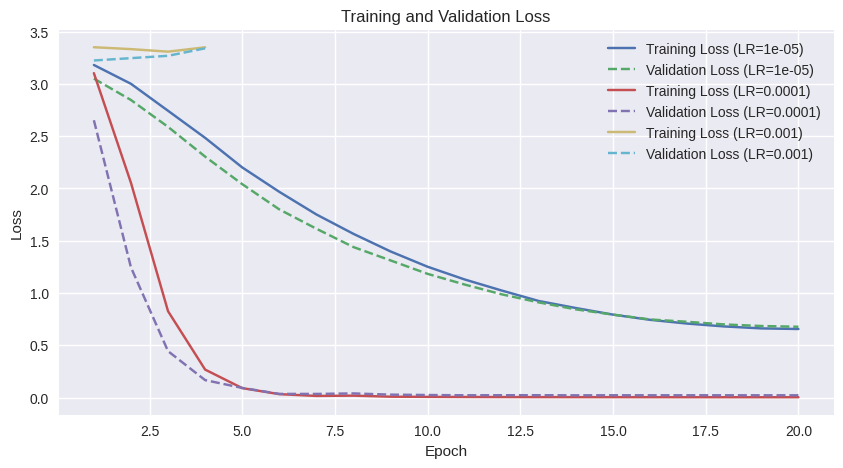

In [20]:
import datetime
import random
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define learning rates
learning_rates = [0.00001, 0.0001, 0.001]

# Define epochs and batch sizes
epochs = 20
batch_size = 32
val_batch = 64


# Initialize dictionaries to store metrics for each learning rate
train_metrics = {}
valid_metrics = {}

# Initialize variables to track the best performing model
best_valid_accuracy = 0
best_model_state_dict = None
best_metrics = {}

# Early stopping parameters
patience = 3
early_stopping_counter = 0

# Loop through each learning rate
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # Initialize the model
    model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=24)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define data loaders for training and validation
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(val_data, batch_size=val_batch, shuffle=False)

    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Initialize lists to store metrics for this learning rate
    train_loss_list = []
    train_recall_list = []
    train_f1_list = []
    train_roc_auc_list = []
    train_accuracy_list = []  # New list to store training accuracy
    train_precision_list = []  # New list to store training precision
    valid_loss_list = []
    valid_recall_list = []
    valid_f1_list = []
    valid_roc_auc_list = []
    valid_accuracy_list = []
    valid_precision_list = []  # New list to store validation precision

    # Start the training process
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        total_train_precision = 0
        train_predictions = []
        train_labels = []

        for step, batch in enumerate(train_dataloader):
            # Forward pass
            inputs = {'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels': batch[2].to(device)}
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Calculate training loss
            total_train_loss += loss.item()

            # Calculate training accuracy
            predictions = torch.argmax(logits, dim=1)
            accuracy = (predictions == inputs['labels']).sum().item() / len(predictions)
            total_train_accuracy += accuracy

            # Calculate training precision
            precision = precision_score(inputs['labels'].cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted')
            total_train_precision += precision

            # Store predictions and labels for computing metrics
            train_predictions.extend(predictions.cpu().detach().numpy())
            train_labels.extend(inputs['labels'].cpu().detach().numpy())

        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Calculate average training accuracy
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        # Calculate average training precision
        avg_train_precision = total_train_precision / len(train_dataloader)

        # Calculate training metrics
        train_recall = recall_score(train_labels, train_predictions, average='weighted')
        train_f1 = f1_score(train_labels, train_predictions, average='weighted')
        train_roc_auc = roc_auc_score(label_binarize(train_labels, classes=np.arange(24)),
                                      label_binarize(train_predictions, classes=np.arange(24)),
                                      average='weighted')

        # Print and store metrics
        print(f"Epoch {epoch + 1}/{epochs}:")
        print(f"  Training Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, Recall: {train_recall:.4f}, "
              f"F1: {train_f1:.4f}, AROC: {train_roc_auc:.4f}, Precision: {avg_train_precision:.4f}")

        train_loss_list.append(avg_train_loss)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)
        train_roc_auc_list.append(train_roc_auc)
        train_accuracy_list.append(avg_train_accuracy)
        train_precision_list.append(avg_train_precision)

        # Validation loop
        model.eval()
        total_valid_loss = 0
        total_valid_accuracy = 0
        total_valid_precision = 0
        valid_predictions = []
        valid_labels = []

        with torch.no_grad():
            for batch in valid_dataloader:
                # Forward pass
                inputs = {'input_ids': batch[0].to(device),
                          'attention_mask': batch[1].to(device),
                          'labels': batch[2].to(device)}
                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

                # Calculate validation loss
                total_valid_loss += loss.item()

                # Calculate validation accuracy
                predictions = torch.argmax(logits, dim=1)
                accuracy = (predictions == inputs['labels']).sum().item() / len(predictions)
                total_valid_accuracy += accuracy

                # Calculate validation precision
                precision = precision_score(inputs['labels'].cpu().detach().numpy(), predictions.cpu().detach().numpy(), average='weighted', zero_division="warn")
                total_valid_precision += precision

                # Store predictions and labels for computing metrics
                valid_predictions.extend(predictions.cpu().detach().numpy())
                valid_labels.extend(inputs['labels'].cpu().detach().numpy())

        # Calculate average validation loss
        avg_valid_loss = total_valid_loss / len(valid_dataloader)

        # Calculate average validation accuracy
        avg_valid_accuracy = total_valid_accuracy / len(valid_dataloader)

        # Calculate average validation precision
        avg_valid_precision = total_valid_precision / len(valid_dataloader)

        # Calculate validation metrics
        valid_recall = recall_score(valid_labels, valid_predictions, average='weighted')
        valid_f1 = f1_score(valid_labels, valid_predictions, average='weighted')
        valid_roc_auc = roc_auc_score(label_binarize(valid_labels, classes=np.arange(24)),
                                      label_binarize(valid_predictions, classes=np.arange(24)),
                                      average='weighted')

        # Print and store metrics
        print(f"  Validation Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_accuracy:.4f}, Recall: {valid_recall:.4f}, "
              f"F1: {valid_f1:.4f}, AROC: {valid_roc_auc:.4f}, Precision: {avg_valid_precision:.4f}")

        valid_loss_list.append(avg_valid_loss)
        valid_recall_list.append(valid_recall)
        valid_f1_list.append(valid_f1)
        valid_roc_auc_list.append(valid_roc_auc)
        valid_accuracy_list.append(avg_valid_accuracy)
        valid_precision_list.append(avg_valid_precision)

        # Update best performing model based on validation accuracy
        if avg_valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = avg_valid_accuracy
            best_model_state_dict = model.state_dict()
            best_metrics = {
                'learning_rate': lr,  # Add the learning rate
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'valid_loss': avg_valid_loss,
                'train_accuracy': avg_train_accuracy,
                'valid_accuracy': avg_valid_accuracy,
                'train_recall': train_recall,
                'valid_recall': valid_recall,
                'train_f1': train_f1,
                'valid_f1': valid_f1,
                'train_roc_auc': train_roc_auc,
                'valid_roc_auc': valid_roc_auc,
                'train_precision': avg_train_precision,
                'valid_precision': avg_valid_precision
            }

        # Early stopping
        if epoch > 0 and valid_loss_list[-1] > valid_loss_list[-2]:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break
        else:
            early_stopping_counter = 0

    # Store metrics for this learning rate
    train_metrics[lr] = {
        'loss': train_loss_list,
        'recall': train_recall_list,
        'f1': train_f1_list,
        'roc_auc': train_roc_auc_list,
        'accuracy': train_accuracy_list,
        'precision': train_precision_list
    }
    valid_metrics[lr] = {
        'loss': valid_loss_list,
        'recall': valid_recall_list,
        'f1': valid_f1_list,
        'roc_auc': valid_roc_auc_list,
        'accuracy': valid_accuracy_list,
        'precision': valid_precision_list
    }

# After training loop, load the best model state
model.load_state_dict(best_model_state_dict)

# Print best performing model and its metrics
print("Best Performing Model Metrics:")
print(best_metrics)



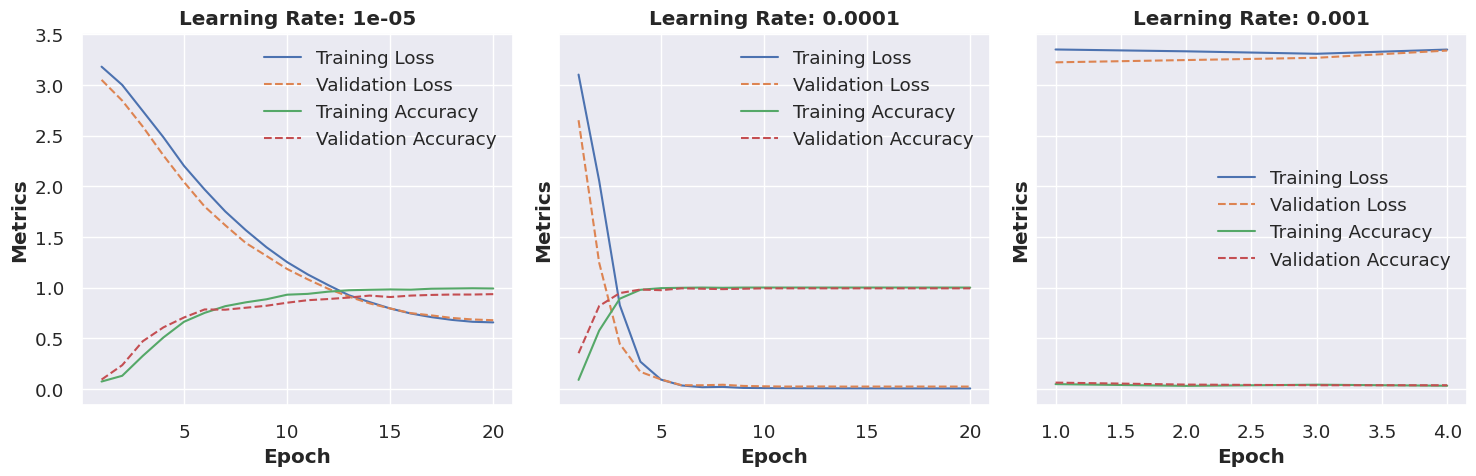

In [67]:
# Plotting the metrics for each learning rate separately
fig, axs = plt.subplots(1, len(learning_rates), figsize=(5*len(learning_rates), 5), sharey=True)

# Loop through each learning rate
for i, lr in enumerate(learning_rates):
    ax = axs[i]
    ax.plot(range(1, len(train_metrics[lr]['loss']) + 1), train_metrics[lr]['loss'], label='Training Loss')
    ax.plot(range(1, len(valid_metrics[lr]['loss']) + 1), valid_metrics[lr]['loss'], label='Validation Loss', linestyle='--')
    ax.plot(range(1, len(train_metrics[lr]['accuracy']) + 1), train_metrics[lr]['accuracy'], label='Training Accuracy')
    ax.plot(range(1, len(valid_metrics[lr]['accuracy']) + 1), valid_metrics[lr]['accuracy'], label='Validation Accuracy', linestyle='--')
    ax.set_xlabel('Epoch', rotation=0, fontweight='bold')  # Rotate x-axis labels by 45 degrees and set to bold
    ax.set_ylabel('Metrics', fontweight='bold')            # Set y-axis label to bold
    ax.set_title(f'Learning Rate: {lr}', fontweight='bold')   # Set title to bold
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()




In [48]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory path to save the model in Google Drive
model_dir_drive = '/content/drive/My Drive/BERTa'

# Create the directory if it doesn't exist
os.makedirs(model_dir_drive, exist_ok=True)

# Save the best model's state dictionary
torch.save(best_model_state_dict, os.path.join(model_dir_drive, "best_model_state_dict.pth"))

# Optionally, save the tokenizer
#tokenizer.save_pretrained(model_dir_drive)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Define the directory path to save the model in Google Drive
model_dir_drive = '/content/drive/My Drive/BERT'

# Create the directory if it doesn't exist
os.makedirs(model_dir_drive, exist_ok=True)

# Save the best model's state dictionary
torch.save(best_model_state_dict, os.path.join(model_dir_drive, "best_model_state_dict.pth"))

# Optionally, save the tokenizer
#tokenizer.save_pretrained(model_dir_drive)

In [65]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the path to the saved model file
saved_model_path = "/content/drive/My Drive/BERT/best_model_state_dict.pth"

# Initialize the model architecture
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=24)

# Load the saved model's state dictionary
state_dict = torch.load(saved_model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Move the model to the appropriate device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store predictions and true labels
all_predictions = []
all_labels = []

#Test Loader
test_dataloader = DataLoader(test_data, batch_size=val_batch, shuffle=False)

# Iterate over batches of test data
for batch in test_dataloader:
    # Move inputs to the appropriate device (e.g., GPU)
    inputs = {'input_ids': batch[0].to(device),
              'attention_mask': batch[1].to(device),
              'labels': batch[2].to(device)}

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Process logits to get predictions
    predictions = torch.argmax(logits, dim=1)

    # Collect predictions and true labels
    all_predictions.extend(predictions.cpu().tolist())
    all_labels.extend(inputs['labels'].cpu().tolist())

# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9916666666666667
Precision: 0.9930555555555556
Recall: 0.9916666666666667
F1-score: 0.9915824915824916
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0]


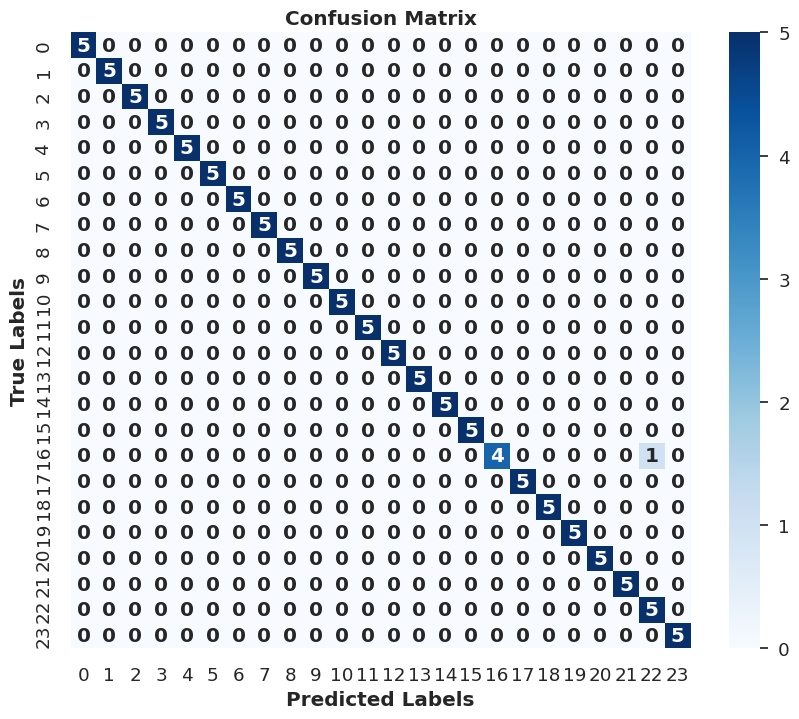

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('True Labels', fontweight='bold')
plt.title('Confusion Matrix', fontweight='bold')
plt.show()

